# Project 3: Crystal Lattice

In this project, we will have in total of __4 simulations__ which will represent a __3x3x3 matrix of atoms__ using __velocity verlet__ integration, __backward Euler__, __forward Euler__ and __Verlet with damped spring__. The structure of the note book will be as follow:
<br>
- Data structure definition
- Helper functions and integration methods
- Undamped simulation and graph
- Damped spring simulation

### Defining a class called "Atom" 

In this code section, we defined several global constants and variable which mainly help with the reset_system() function that will be implemented later. 

**Plotting method**: In order to **monitor and plot** kinetic, potential and total energy of the system over time, we use global lists such as **kinetic_energies**, **potential_energies**, **total_energies** and combine it with list **times** for ploting using matplotlib
<br>
<br>
__Data Structure__: Instead of defining a __system class__ in the reference code, we create a __class__ called __"Atom"__ for the atom object in the system. That way we can find neighbors and access each inidivual __objects__ and __attributes__ easier. The atom's class significant attributes are __origin__ and __neighbor attributes__. 
- origin: An Atom initial position. That way we can calculate the spring force of each atom seperately and then combine them back together when calculating net force on one atom to avoid double counting the force
- neighbor: A list storing an atom neighbors, which will be a list of other atom objects. 
- total_force(self, k): Run through an atom's list of neighbor, then calculate the net force impacted on that atom.
- total_force(self, k, b): Same function as the total_force() method above but also put damping force in to account

In [1]:
from vpython import *
import numpy as np
import random
import matplotlib.pyplot as plt

global t, dt, times, potential_energies, kinetic_energies, total_energies

class Atom:
    def __init__(self, position, velocity):
        self.position = vec(*position)
        self.velocity = vec(*velocity)
        self.origin = vec(*position)
        self.mass = 1
        self.obj = sphere(pos=self.position, radius=0.3, color=vector(0,0.58,0.69))
        self.neighbors = []
        self.distance = {}
                
    def total_force(self, k):
        net_force = vector(0, 0, 0)
        for neighbor in self.neighbors:
            f1 = -k*(self.position - self.origin)
            f2 = -k*(neighbor.position - neighbor.origin)
            f = f1 + f2
            net_force += f
        return net_force
    
    def total_force_damping(self, k, b):
        net_force = vector(0, 0, 0)
        for neighbor in self.neighbors:
            f1 = -k*(self.position - self.origin)
            f2 = -k*(neighbor.position - neighbor.origin)
            f_damping = -b * self.velocity
            f = f1 + f2 + f_damping
            net_force += f
        return net_force

<IPython.core.display.Javascript object>

### Defining helper functions and intergration methods

- **calculate_energy(matrix, kinetic_energy, potential_energy, time, t)**: Find the kinetic energy and potential energy of the system at a specific time step, then appending KE, PE, and time step value to a list for plotting later
- **plot_energy()**: A function to plot potential, kinetic and total energy of the system
- **update_pos_verlet(atom, dt, k)**: update a specific atom position with a desired dt and spring constant using **velocity verlet** integration
- **update_pos_backwardEuler(atom, dt, k)**: update a specific atom position using **Backward Euler** which uses v(t) to calculate the position first then update new velocity v(t + dt)
- **update_pos_forwardEuler(atom, dt, k)**: update a specific atom position using **Forward Euler** which find v(t + dt) first the using that next state velocity to find the position of the atom
- **update_pos_damping(atom, dt, k)**: update a specific atom positon using **verlet** integration with **spring damping** 

In [2]:
def calculate_energy(matrix, kinetic_energy, potential_energy, time, t):
    KE = 0
    PE = 0
    for x in range(-1, 2):
        for y in range(-1, 2):
            for z in range(-1, 2):
                atom = matrix[x][y][z]
                KE += 0.5 * atom.mass * dot(atom.velocity, atom.velocity)
                PE += 0.5  * k *mag(atom.position - atom.origin)**2
    
    # Append energy values to lists
    potential_energy.append(PE)
    kinetic_energy.append(KE)
    time.append(t)

def plot_energy():
    # Plot energy values
    plt.plot(times, potential_energies, label='Potential Energy')
    plt.plot(times, kinetic_energies, label='Kinetic Energy')
    plt.plot(times, [potential_energies[i] + kinetic_energies[i] for i in range(len(times))], label='Total Energy')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.show()
    
def update_pos_verlet(atom, dt, k):
    F1 = atom.total_force(k)    # Update position using Verlet algorithm
    atom.position += atom.velocity * dt + 0.5 * (F1 / atom.mass) * dt ** 2     # Compute force at new position
    F2 = atom.total_force(k)    # Update velocity using Verlet algorithm
    atom.velocity += 0.5 * ((F1 + F2) / atom.mass) * dt            # Update the sphere object position
    atom.obj.pos = atom.position

def update_pos_backwardEuler(atom, dt, k):
    # Update position first then find next velocity
    atom.position += atom.velocity*dt
    atom.obj.pos = atom.position
    F = atom.total_force(k)
    acceleration = F/atom.mass
    atom.velocity += acceleration*dt
    
def update_pos_forwardEuler(atom, dt, k):
    # Update position with next velocity
    F = atom.total_force(k)
    acceleration = F/atom.mass
    atom.velocity += acceleration*dt
    atom.position += atom.velocity*dt
    atom.obj.pos = atom.position
    
def update_pos_damping(atom, dt, k, b):
    F1 = atom.total_force_damping(k, b)    # Update position using Verlet algorithm
    atom.position += atom.velocity * dt + 0.5 * (F1 / atom.mass) * dt ** 2     # Compute force at new position
    F2 = atom.total_force_damping(k, b)    # Update velocity using Verlet algorithm
    atom.velocity += 0.5 * ((F1 + F2) / atom.mass) * dt            # Update the sphere object position
    atom.obj.pos = atom.position

### Defining function to Initilize and Reset the system

- **reset_system():** reset global variables and constant for the simulation to re-run and avoid duplication while plotting
- **init_system():** initialize the system by creating a **3-dimensional numpy array** called atoms_matrix with (-1, 0, 1) indexing. While looping through each index of the 3D array to create object, it also initilize random velocity for each atom using **random.uniform()**. Next, the function loops through the matrix to find all corresponding neighbor for each atom

In [3]:
def reset_system():
    global t, dt, times, potential_energies, kinetic_energies, total_energies
    t = 0
    dt = 0.01
    times = [0]
    potential_energies = [0]
    kinetic_energies = [0]
    total_energies = [0]

def init_system():
    scene = canvas()
    
    # Initialize a 3D numpy array storing Atom objects to create a 3x3x3 matrix of atom
    atoms_matrix = np.empty((3, 3, 3), dtype=Atom)
    for i in range(-1, 2):
        for j in range(-1, 2):
            for k in range(-1, 2):
                position = [i, j, k]
                velocity = [random.uniform(-0.3, 0.3), random.uniform(-0.3, 0.3), random.uniform(-0.3, 0.3)]
                atoms_matrix[i][j][k] = Atom(position, velocity)
    
    # Finding corresponding neighbors for each atom in the system
    for x in range(-1, 2):
        for y in range(-1, 2):
            for z in range(-1, 2):
                atom = atoms_matrix[x][y][z]
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        for dz in [-1, 0, 1]:
                            if dx == dy == dz == 0:
                                continue  # Skip the central atom
                            nx = x + dx
                            ny = y + dy
                            nz = z + dz
                            if -1 <= nx < 2 and -1 <= ny < 2 and -1 <= nz < 2:
                                neighbor = atoms_matrix[nx][ny][nz]
                                atom.neighbors.append(neighbor)
                                distance = norm(neighbor.position - atom.position)
                                atom.distance[neighbor] = distance
    return atoms_matrix
                        

# Molecular Crystal Structure (Undamped)

**OVerview**: In this simulation section, we will have 3 simulation which covers 3 integration method. Each code block will simulate a certain amount of time then show a plot of Kinetic, Potential and Total Energy. 

**Validation**: From our observation we can visually confirm that the system behave the way we wanted thus partly validate our simumation. From the graph we can see that through every time step, each Kinetic Energy peaks at t will also have a Potential Energy drop and vice versa. This prove that the total energy of the system is constantly conserved from Kinetic Energy converting into Potential Energy and vice versa. In addition, with damping spring force not taken accounted for, **despite the fluctuation, the whole system does not experience a loss of total energy** as shown in each simulation graph

## Simulation 1: Velocity Verlet Integration

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

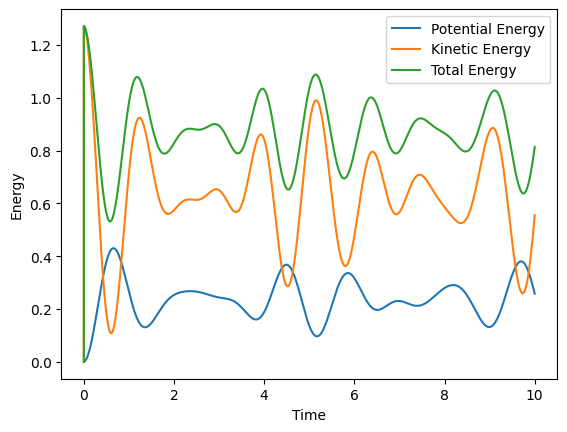

In [4]:
reset_system()
atoms_matrix = init_system()
dt = 0.01

while t < 10:
    rate(100)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                atom = atoms_matrix[i][j][k]
                update_pos_verlet(atom, dt, 0.5)
    calculate_energy(atoms_matrix, kinetic_energies, potential_energies, times, t) 
    t += dt
plot_energy()

**Observation**: we can see that using a smaller time step such as **dt = 0.01** results in the system moving a lot smoother but slower so we have to shorten the **run time to 10**. The Total Energy is mainly conserved around 0.8 to 1 and fluctuates do to other aspect such as spring constant, equilibrium distance and integration method.

## Simulation 2: Backward Euler Integration

<IPython.core.display.Javascript object>

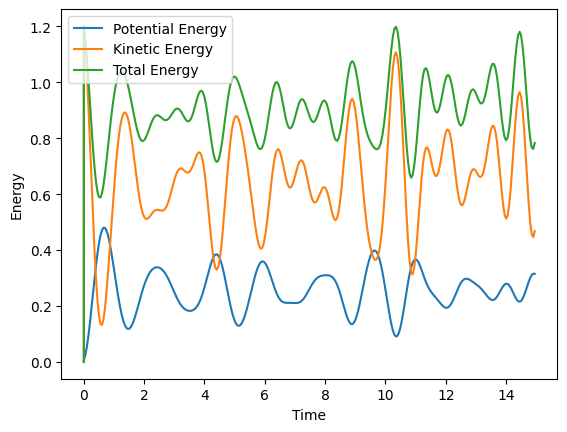

In [5]:
reset_system()
atoms_matrix = init_system()
dt = 0.05

while t < 15:
    rate(100)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                atom = atoms_matrix[i][j][k]
                update_pos_backwardEuler(atom, dt, 0.5)
    calculate_energy(atoms_matrix, kinetic_energies, potential_energies, times, t) 
    t += dt
plot_energy()

**Observation**: We can see that the simulation move very fast with **dt = 0.05** so **t < 15** is long enough for us to observe the system behavior. We can also see that the graph fluctuates a lot less using Backward Euler integration. However, the accuracy seems to decrease because there are some spot where Kinetic Energy and Potential Energy increase at the same time such as at **t = 2.9**.

## Simulation 3: Forward Euler Integration

<IPython.core.display.Javascript object>

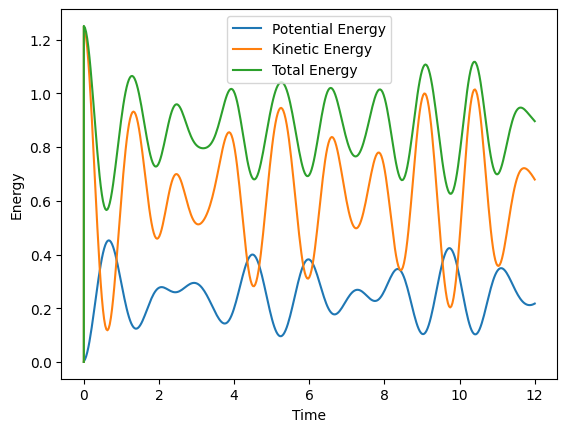

In [6]:
reset_system()
atoms_matrix = init_system()

dt = 0.03

while t < 12:
    rate(100)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                atom = atoms_matrix[i][j][k]
                update_pos_forwardEuler(atom, dt, 0.5)
    calculate_energy(atoms_matrix, kinetic_energies, potential_energies, times, t) 
    t += dt
plot_energy()

**Observation**: We can see that the simulation moves well with **dt = 0.03** and **t < 12** is adequate for us to observe the system behavior. By using Forward integration we can see that all peaks of Kinetic Energy correspond to all lows of Potential Energy, which means this integration may be the most accurate out of the three can be infered with this simulation result

# Molecular Crystal Structure (Spring Damping)

## Simulation 4: Verlet Integeration with Spring Damping

<IPython.core.display.Javascript object>

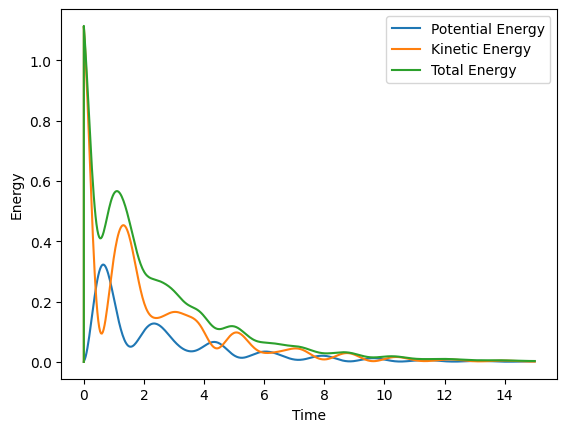

In [7]:
reset_system()
atoms_matrix = init_system()

dt = 0.03
b = 0.04

while t < 15:
    rate(100)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                atom = atoms_matrix[i][j][k]
                update_pos_damping(atom, dt, 0.5, b)
    calculate_energy(atoms_matrix, kinetic_energies, potential_energies, times, t) 
    t += dt
plot_energy()

**Observaton**: The simulation starts off with atoms exerting forces onto each other resulting in the system wobbleness. But due to the extra damping spring force, total energy was not conserved and gradually decreases. We can visually confirm the loss of energy by observing the loss of movement of the system as it slowly become still at the end, which validates our simulation.